In [8]:
import os
cur_dir = os.getcwd()
base_dir = os.path.dirname(os.path.dirname(cur_dir))
import sys
sys.path.append(base_dir)
from utils.load_data import load_classification
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb

# load data
train_df, test_df, target = load_classification()

# Data Preparation

In [24]:
# 查看缺测数据：
null_value_stats = train_df.isnull().sum(axis=0)
print(null_value_stats[null_value_stats != 0])

# 填充缺失值：
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

# 拆分features和label
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

# 对于category的特征，如果不做one-hot，可以将它们类型改为category
# 因为LGBM可以自己处理category的特征
cat_feas = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
X[cat_feas] = X[cat_feas].astype('category')

# train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = test_df

Series([], dtype: int64)


# Model

In [41]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 190,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# generate feature names
feature_name = list(X_train.columns)

evals_result = {}  # to record eval results for plotting

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=100,
                evals_result=evals_result,
                verbose_eval=50)

Starting training...
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.511619	valid_1's binary_logloss: 0.528253
[100]	training's binary_logloss: 0.435159	valid_1's binary_logloss: 0.4654
[150]	training's binary_logloss: 0.389449	valid_1's binary_logloss: 0.4399
[200]	training's binary_logloss: 0.356606	valid_1's binary_logloss: 0.427344
[250]	training's binary_logloss: 0.331193	valid_1's binary_logloss: 0.423125
[300]	training's binary_logloss: 0.307218	valid_1's binary_logloss: 0.419824
[350]	training's binary_logloss: 0.287644	valid_1's binary_logloss: 0.418045
[400]	training's binary_logloss: 0.270337	valid_1's binary_logloss: 0.420354
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.29288	valid_1's binary_logloss: 0.417415


In [38]:
lgb_train.feature_name

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

# Plot metrics recorded during training

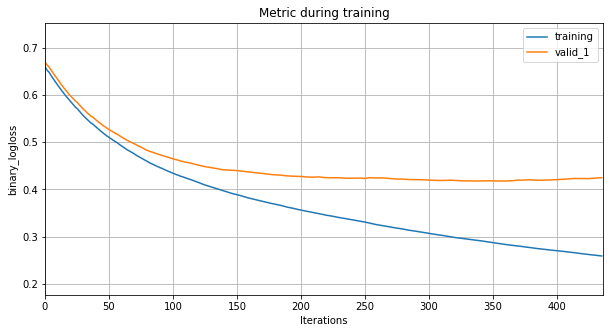

In [44]:
import matplotlib.pyplot as plt
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()
    
render_metric('binary_logloss')

# Plot feature importances

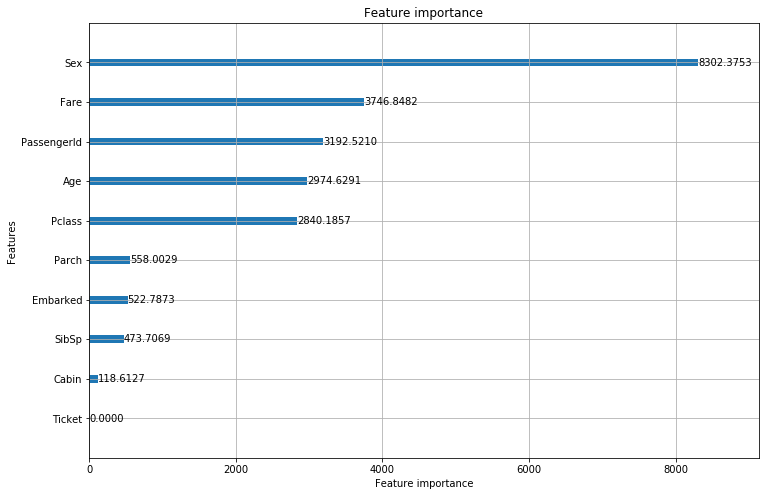

In [46]:
def render_plot_importance(importance_type='gain', max_features=10, ignore_zero=False, precision=4):
    """
    importance_type: 'split','gain'    
    """
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

render_plot_importance(importance_type='gain')